In [1]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 12]

In [2]:
def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label        
    return label.loc[0]

In [3]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.ix[0]   

In [4]:
def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

In [5]:
def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

In [6]:
def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches

In [7]:
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches

In [8]:
def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''
    
    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

In [9]:
def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

In [10]:
def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    #Return total wins
    return total_wins 

In [11]:
def get_match_features(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    #Create match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]

In [12]:
def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''

    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    #Get match features for all matches
    match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
    
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating match labels...")
    start = time()
    
    #Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating bookkeeper data...")
    start = time()
    
    #Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

    #Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    feables.dropna(inplace = True)
    
    #Return preprocessed data
    return feables

In [13]:
def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''
    
    #Start the clock, train the classifier, then stop the clock
    start = time()
    
    #Check if grid search should be applied
    if use_grid_search == True: 
        
        #Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)
        
        #Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:
        
        #Use best components that are known without grid search        
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)        
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Return best pipe
    return best_pipe

In [14]:
def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''
    
    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    #Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)

In [15]:
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs

In [16]:
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
        #Check if data should be aggregated horizontally
        if(horizontal == True):
            
            #Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    #Return bookkeeper data
    return bk_data

In [17]:
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    #Return data
    return probs

In [18]:
def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

In [19]:
def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table 
    
    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, defeats])
    
    #Return total
    return total

In [20]:
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    #Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    #Return choices
    return choices

In [21]:
def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    
    #Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols
    
    #Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")
    
    #Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0
    
    #Return reward
    return reward

In [22]:
def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''    
    
    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0
    
    #Loop through bets
    loops = np.arange(0, bet_choices.shape[0])     
    for i in loops:
        
        #Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1
    
    #Compute investment return
    investment_return = float(total_reward / total_invested) - 1
    
    #Return investment return
    return investment_return

In [23]:
def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''
    
    #Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    #Loop through features    
    i = 1
    for col in features.columns:
        
        #Set subplot and plot format        
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1
        
        #Plot KDE for all labels
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
        sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
        plt.legend();
        i = i + 1
    
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()
    
    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    
    #Store description of all features
    feature_details = features.describe().transpose()

    #Return feature details
    return feature_details

In [24]:
def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''
    
    #Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []
    
    #Loop through dimensionality reductions
    for dm in dm_reductions:
        
        #Loop through classifiers
        for clf in clfs:
            
            #Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
            #Append the result to storage            
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)
    
    #Return storage
    return clfs_return, dm_reduce_return, train_scores, test_scores

In [25]:
def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''
    
    #Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0.5
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []
    
    #Loop throuugh classifiers
    for i in range(0, len(clfs)): 
        
        #Define temporary variables        
        clf = clfs[i]
        clf_name = clf.base_estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__
        
        #Create and store name
        name = "{} with {}".format(clf_name, dm_name)
        names.append(name)
        
    #Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)
    
    plt.show()

In [26]:
def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    ''' Tune parameters of bet selection algorithm. '''
    
    #Generate data samples
    samples = []
    for i in range(0, n_samples):
        sample = match_data.sample(n = sample_size, random_state = 42)
        samples.append(sample)
    
    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0
    
    #Iterate over all 1 parameter
    for i in parameter_1_grid:
        
        #Iterate over all 2 parameter
        for j in parameter_2_grid:
            
            #Compute average score over all samples
            profits = []
            for sample in samples:
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row,"results"] = result
            results.loc[row,"parameter_1"] = i
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))
               
    #Return best setting and result
    best_result = results.ix[results['results'].idxmax()] 
    return best_result

In [27]:
def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose = False, normalize = True):
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose == True: print("Obtaining labels...")
    
    #Get match labels
    y_test_temp = matches.apply(get_match_label, axis = 1)
    
    if verbose == True: print("Obtaining bookkeeper probabilities...")
    
    #Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    bookkeeper_probs.dropna(inplace = True)
    
    if verbose == True: print("Obtaining bookkeeper labels...")
    
    #Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
    y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
    if verbose == True: print("Plotting confusion matrix...")
    
    #Format data
    results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']
    
    #Generate confusion matrix
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels) 
    
    #Check for normalization
    if normalize == True:
        cm = cm.astype('float') / cm.sum()
        
    #Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title = "Confusion matrix of Bookkeeper predictions!"   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report and accuracy score of bookkeepers
    print(classification_report(y_test, y_pred)) 
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))

### Doing things now...

In [28]:
## Fetching data
#Connecting to database
path = "soccer_database.sqlite"  #Insert path here
conn = sqlite3.connect(path)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 2 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match where country_id = 1729;", conn)

match_data.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [29]:
team_data.head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [30]:
player_data.head(5)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [31]:
player_stats_data.head(5)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [32]:
with_team_names = match_data.merge(
    team_data, 
    how='inner', 
    left_on=['home_team_api_id'], 
    right_on=['team_api_id'], 
    suffixes=('', '_home')
).merge(
    team_data, 
    how='inner', 
    left_on=['away_team_api_id'], 
    right_on=['team_api_id'], 
    suffixes=('', '_away')
)
with_team_names.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,id_home,team_api_id,team_fifa_api_id,team_long_name,team_short_name,id_away,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,3457,10260,11.0,Manchester United,MUN,3458,10261,13.0,Newcastle United,NEW


In [33]:
## Fetching data
#Connecting to database
path = "soccer_database.sqlite"  #Insert path here
conn = sqlite3.connect(path)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 2 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

#Reduce match data to fulfill run time requirements
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)

In [34]:
match_data.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
145,146,1,1,2008/2009,24,2009-02-27 00:00:00,493017,8203,9987,2,...,2.30,2.65,3.25,2.35,2.90,3.25,2.30,2.80,3.2,2.25
153,154,1,1,2008/2009,25,2009-03-08 00:00:00,493025,9984,8342,1,...,2.25,2.65,3.20,2.35,2.90,3.20,2.30,2.62,3.2,2.38
155,156,1,1,2008/2009,25,2009-03-07 00:00:00,493027,8635,10000,2,...,8.50,1.30,4.35,8.00,1.35,4.33,8.50,1.36,4.2,7.00
162,163,1,1,2008/2009,26,2009-03-13 00:00:00,493034,8203,8635,2,...,1.73,4.35,3.30,1.75,4.50,3.40,1.75,4.20,3.3,1.75
168,169,1,1,2008/2009,26,2009-03-14 00:00:00,493040,10000,9999,0,...,5.00,1.65,3.50,4.50,1.65,3.50,5.00,1.70,3.4,4.33


In [35]:
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

#Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']     
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)
#feature_details = explore_data(features, inputs, path)

#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


KeyboardInterrupt: 

In [39]:
## Initializing all models and parameters
#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB_clf = GaussianNB()
KNN_clf =  KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_GNB = {'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_KNN = {'clf__n_neighbors': [3, 5, 10], 
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5), 
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5))}

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_GNB,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG}

#Initializing dimensionality reductions
pca = PCA()
dm_reductions = [pca]

/usr/local/lib/python3.7/site-packages/numpy/core/function_base.py:233: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [40]:
## Training a baseline model and finding the best model composition using grid search
#Train a simple GBC classifier as baseline model
clf = LOG_clf
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

#Training all classifiers and comparing them
clfs, dm_reductions, train_scores, test_scores = find_best_classifier(clfs, dm_reductions, scorer, X_train, y_train, 
                                                                    X_calibrate, y_calibrate, X_test, y_test, cv_sets, 
                                                                      parameters, n_jobs)

#Plotting train and test scores
plot_training_results(clfs, dm_reductions, np.array(train_scores), np.array(test_scores), path = path)

Score of LogisticRegression for training set: 0.6145.
Score of LogisticRegression for test set: 0.5077.
Training a RandomForestClassifier with PCA...


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py in _run_code(code=<code object <module> at 0x10a7dcf60, file "/usr...3.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor...ges/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/C.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10a7dcf60, file "/usr...3.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor...ges/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/C.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 10, 49, 16, 437134, tzinfo=tzutc()), 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'session': 'b64cd01c27d44fff8df3ccaa5655f424', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'b64cd01c27d44fff8df3ccaa5655f424']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 10, 49, 16, 437134, tzinfo=tzutc()), 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'session': 'b64cd01c27d44fff8df3ccaa5655f424', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'b64cd01c27d44fff8df3ccaa5655f424'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 7, 21, 10, 49, 16, 437134, tzinfo=tzutc()), 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'session': 'b64cd01c27d44fff8df3ccaa5655f424', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'f716ec42301746138f3a4d3734fb42ba', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/vendor/lib/python3.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='## Training a baseline model and finding the bes...rain_scores), np.array(test_scores), path = path)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-40-1cd85e79abc5>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1144c4828, execution_...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x114ca9540, file "<ipython-input-40-1cd85e79abc5>", line 9>
        result = <ExecutionResult object at 1144c4828, execution_...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/usr/local/Cellar/ipython/6.4.0_1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x114ca9540, file "<ipython-input-40-1cd85e79abc5>", line 9>, result=<ExecutionResult object at 1144c4828, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x114ca9540, file "<ipython-input-40-1cd85e79abc5>", line 9>
        self.user_global_ns = {'AB_clf': AdaBoostClassifier(algorithm='SAMME.R', base_est...rning_rate=1.0, n_estimators=200, random_state=2), 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'CalibratedClassifierCV': <class 'sklearn.calibration.CalibratedClassifierCV'>, 'FastICA': <class 'sklearn.decomposition.fastica_.FastICA'>, 'GNB_clf': GaussianNB(priors=None), 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'In': ['', '## Importing required libraries\nimport sqlite3\ni...CA, FastICA\nfrom sklearn.pipeline import Pipeline', "def get_match_label(match):\n    ''' Derives a la...    #Return label        \n    return label.loc[0]", "def get_fifa_stats(match, player_stats):\n    '''...er stats    \n    return player_stats_new.ix[0]   ", 'def get_fifa_data(matches, player_stats, path = ...)\n    \n    #Return fifa_data\n    return fifa_data', 'def get_overall_fifa_rankings(fifa, get_overall ...= temp_data\n    \n    #Return data\n    return data', 'def get_last_matches(matches, date, team, x = 10...\n    #Return last matches\n    return last_matches', 'def get_last_matches_against_eachother(matches, ...        \n    #Return data\n    return last_matches', "def get_goals(matches, team):\n    ''' Get the go...  \n    #Return total goals\n    return total_goals", "def get_goals_conceided(matches, team):\n    ''' ...s\n\n    #Return total goals\n    return total_goals", "def get_wins(matches, team):\n    ''' Get the num...ns\n\n    #Return total wins\n    return total_wins ", 'def get_match_features(match, matches, x = 10):\n...  #Return match features\n    return result.loc[0]', 'def create_feables(matches, fifa, bookkeepers, g...\n    #Return preprocessed data\n    return feables', 'def train_classifier(clf, dm_reduction, X_train,...)\n    \n    #Return best pipe\n    return best_pipe', 'def train_calibrate_predict(clf, dm_reduction, X...), predict_labels(clf, best_pipe, X_test, y_test)', "def convert_odds_to_prob(match_odds):\n    ''' Co...\n    #Return probs and meta data\n    return probs", 'def get_bookkeeper_data(matches, bookkeepers, ho...  \n    #Return bookkeeper data\n    return bk_data', 'def get_bookkeeper_probs(matches, bookkeepers, h...prob(data)\n    \n    #Return data\n    return probs', 'def plot_confusion_matrix(y_test, X_test, clf, d...    print(classification_report(y_test, y_pred)) ', 'def compare_probabilities(clf, dim_reduce, bk, b...defeats])\n    \n    #Return total\n    return total', ...], 'KNN_clf': KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
        self.user_ns = {'AB_clf': AdaBoostClassifier(algorithm='SAMME.R', base_est...rning_rate=1.0, n_estimators=200, random_state=2), 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'CalibratedClassifierCV': <class 'sklearn.calibration.CalibratedClassifierCV'>, 'FastICA': <class 'sklearn.decomposition.fastica_.FastICA'>, 'GNB_clf': GaussianNB(priors=None), 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'In': ['', '## Importing required libraries\nimport sqlite3\ni...CA, FastICA\nfrom sklearn.pipeline import Pipeline', "def get_match_label(match):\n    ''' Derives a la...    #Return label        \n    return label.loc[0]", "def get_fifa_stats(match, player_stats):\n    '''...er stats    \n    return player_stats_new.ix[0]   ", 'def get_fifa_data(matches, player_stats, path = ...)\n    \n    #Return fifa_data\n    return fifa_data', 'def get_overall_fifa_rankings(fifa, get_overall ...= temp_data\n    \n    #Return data\n    return data', 'def get_last_matches(matches, date, team, x = 10...\n    #Return last matches\n    return last_matches', 'def get_last_matches_against_eachother(matches, ...        \n    #Return data\n    return last_matches', "def get_goals(matches, team):\n    ''' Get the go...  \n    #Return total goals\n    return total_goals", "def get_goals_conceided(matches, team):\n    ''' ...s\n\n    #Return total goals\n    return total_goals", "def get_wins(matches, team):\n    ''' Get the num...ns\n\n    #Return total wins\n    return total_wins ", 'def get_match_features(match, matches, x = 10):\n...  #Return match features\n    return result.loc[0]', 'def create_feables(matches, fifa, bookkeepers, g...\n    #Return preprocessed data\n    return feables', 'def train_classifier(clf, dm_reduction, X_train,...)\n    \n    #Return best pipe\n    return best_pipe', 'def train_calibrate_predict(clf, dm_reduction, X...), predict_labels(clf, best_pipe, X_test, y_test)', "def convert_odds_to_prob(match_odds):\n    ''' Co...\n    #Return probs and meta data\n    return probs", 'def get_bookkeeper_data(matches, bookkeepers, ho...  \n    #Return bookkeeper data\n    return bk_data', 'def get_bookkeeper_probs(matches, bookkeepers, h...prob(data)\n    \n    #Return data\n    return probs', 'def plot_confusion_matrix(y_test, X_test, clf, d...    print(classification_report(y_test, y_pred)) ', 'def compare_probabilities(clf, dim_reduce, bk, b...defeats])\n    \n    #Return total\n    return total', ...], 'KNN_clf': KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/matt/src/soccer/<ipython-input-40-1cd85e79abc5> in <module>()
      6 print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))
      7 
      8 #Training all classifiers and comparing them
      9 clfs, dm_reductions, train_scores, test_scores = find_best_classifier(clfs, dm_reductions, scorer, X_train, y_train, 
     10                                                                     X_calibrate, y_calibrate, X_test, y_test, cv_sets, 
---> 11                                                                       parameters, n_jobs)
     12 
     13 #Plotting train and test scores
     14 plot_training_results(clfs, dm_reductions, np.array(train_scores), np.array(test_scores), path = path)

...........................................................................
/Users/matt/src/soccer/<ipython-input-24-d4f1b507a414> in find_best_classifier(classifiers=[RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_est...rning_rate=1.0, n_estimators=200, random_state=2), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), LogisticRegression(C=1.0, class_weight='balanced...r='sag', tol=0.0001, verbose=0, warm_start=False)], dm_reductions=[PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False)], scorer=make_scorer(accuracy_score), X_t=     home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], y_t=172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, X_c=     home_team_goals_difference  away_team_goals...26  0.128591   0.074583  

[78 rows x 36 columns], y_c=95     Defeat
191       Win
206       Win
193   ...       Win
Name: label, Length: 78, dtype: object, X_v=     home_team_goals_difference  away_team_goals...48  0.311869   0.328283  

[65 rows x 36 columns], y_v=33       Draw
213    Defeat
298       Win
295   ...      Draw
Name: label, Length: 65, dtype: object, cv_sets=StratifiedShuffleSplit(n_splits=5, random_state=5, test_size=0.2,
            train_size=None), params={RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False): {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, AdaBoostClassifier(algorithm='SAMME.R', base_est...rning_rate=1.0, n_estimators=200, random_state=2): {'clf__learning_rate': array([0.5  , 0.875, 1.25 , 1.625, 2.   ]), 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, GaussianNB(priors=None): {'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'): {'clf__n_neighbors': [3, 5, 10], 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, LogisticRegression(C=1.0, class_weight='balanced...r='sag', tol=0.0001, verbose=0, warm_start=False): {'clf__C': array([1.00000000e+001, 5.62341325e+250,             inf,             inf,
                   inf]), 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}}, jobs=2)
     15             
     16             #Grid search, calibrate, and test the classifier
     17             clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
     18                                                       X_calibrate = X_c, y_calibrate = y_c,
     19                                                       X_test = X_v, y_test = y_v, cv_sets = cv_sets,
---> 20                                                       params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
     21             
     22             #Append the result to storage            
     23             clfs_return.append(clf)
     24             dm_reduce_return.append(dm_reduce)

...........................................................................
/Users/matt/src/soccer/<ipython-input-14-6dd33c081f33> in train_calibrate_predict(clf=RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), dm_reduction=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), X_train=     home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], y_train=172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, X_calibrate=     home_team_goals_difference  away_team_goals...26  0.128591   0.074583  

[78 rows x 36 columns], y_calibrate=95     Defeat
191       Win
206       Win
193   ...       Win
Name: label, Length: 78, dtype: object, X_test=     home_team_goals_difference  away_team_goals...48  0.311869   0.328283  

[65 rows x 36 columns], y_test=33       Draw
213    Defeat
298       Win
295   ...      Draw
Name: label, Length: 65, dtype: object, cv_sets=StratifiedShuffleSplit(n_splits=5, random_state=5, test_size=0.2,
            train_size=None), params={'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, scorer=make_scorer(accuracy_score), jobs=2, use_grid_search=True, **kwargs={})
      4     
      5     #Indicate the classifier and the training set size
      6     print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
      7     
      8     #Train the classifier
----> 9     best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
     10     
     11     #Calibrate classifier
     12     print("Calibrating probabilities of classifier...")
     13     start = time()    

...........................................................................
/Users/matt/src/soccer/<ipython-input-13-70001b54e82d> in train_classifier(clf=RandomForestClassifier(bootstrap=True, class_wei...state=1,
            verbose=0, warm_start=False), dm_reduction=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), X_train=     home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], y_train=172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, cv_sets=StratifiedShuffleSplit(n_splits=5, random_state=5, test_size=0.2,
            train_size=None), params={'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': array([ 5., 12., 19., 26., 33.])}, scorer=make_scorer(accuracy_score), jobs=2, use_grid_search=True, best_components=None, best_params=None)
     12         estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
     13         pipeline = Pipeline(estimators)
     14         
     15         #Grid search over pipeline and return best classifier
     16         grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
---> 17         grid_obj.fit(X_train, y_train)
     18         best_pipe = grid_obj.best_estimator_
     19     else:
     20         
     21         #Use best components that are known without grid search        

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedShuffleSplit(n_splits=...  scoring=make_scorer(accuracy_score), verbose=0), X=     home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], y=172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedShuffleSplit.split of St...e=5, test_size=0.2,
            train_size=None)>
        X =      home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns]
        y = 172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Sat Jul 21 12:49:16 2018
PID: 11757                Python 3.7.0: /usr/local/opt/python/bin/python3.7
...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('dm_reduce', ...te=1,
            verbose=0, warm_start=False))]),      home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], 172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, {'score': make_scorer(accuracy_score)}, array([157,  81, 131, 125,  65,  83,  16, 164, 1...33, 151, 128, 176, 100, 173,  58, 136,  98, 140]), array([ 50,   4,  21, 121,  93, 112, 107, 169, 1...53,   1,  88, 155, 122, 126,  48,  46,  34,  57]), 0, {'clf__max_features': 'auto', 'dm_reduce__n_components': 5.0}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('dm_reduce', ...te=1,
            verbose=0, warm_start=False))]),      home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], 172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, {'score': make_scorer(accuracy_score)}, array([157,  81, 131, 125,  65,  83,  16, 164, 1...33, 151, 128, 176, 100, 173,  58, 136,  98, 140]), array([ 50,   4,  21, 121,  93, 112, 107, 169, 1...53,   1,  88, 155, 122, 126,  48,  46,  34,  57]), 0, {'clf__max_features': 'auto', 'dm_reduce__n_components': 5.0})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('dm_reduce', ...te=1,
            verbose=0, warm_start=False))]), X=     home_team_goals_difference  away_team_goals...2  0.275485   0.267614  

[179 rows x 36 columns], y=172      Draw
148      Draw
68        Win
181   ...      Win
Name: label, Length: 179, dtype: object, scorer={'score': make_scorer(accuracy_score)}, train=array([157,  81, 131, 125,  65,  83,  16, 164, 1...33, 151, 128, 176, 100, 173,  58, 136,  98, 140]), test=array([ 50,   4,  21, 121,  93, 112, 107, 169, 1...53,   1,  88, 155, 122, 126,  48,  46,  34,  57]), verbose=0, parameters={'clf__max_features': 'auto', 'dm_reduce__n_components': 5.0}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...e=1,
            verbose=0, warm_start=False))])>
        X_train =      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns]
        y_train = 217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('dm_reduce', ...te=1,
            verbose=0, warm_start=False))]), X=     home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], y=217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N...e=1,
            verbose=0, warm_start=False))])>
        X =      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns]
        y = 217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('dm_reduce', ...te=1,
            verbose=0, warm_start=False))]), X=     home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], y=217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'clf': {}, 'dm_reduce': {}}
        name = 'dm_reduce'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x1121c0378>), *args=(PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), None,      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], 217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), None,      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], 217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), weight=None, X=     home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], y=217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method PCA.fit_transform of PCA(copy=True...one,
  svd_solver='auto', tol=0.0, whiten=False)>
        X =      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns]
        y = 217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py in fit_transform(self=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), X=     home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns], y=217       Win
318       Win
307    Defeat
97    ...      Win
Name: label, Length: 143, dtype: object)
    343         Returns
    344         -------
    345         X_new : array-like, shape (n_samples, n_components)
    346 
    347         """
--> 348         U, S, V = self._fit(X)
        U = undefined
        S = undefined
        V = undefined
        self._fit = <bound method PCA._fit of PCA(copy=True, iterate...one,
  svd_solver='auto', tol=0.0, whiten=False)>
        X =      home_team_goals_difference  away_team_goals...7  0.291684   0.311129  

[143 rows x 36 columns]
    349         U = U[:, :self.n_components_]
    350 
    351         if self.whiten:
    352             # X_new = X * V / S * sqrt(n_samples) = U * sqrt(n_samples)

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py in _fit(self=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), X=array([[-6.33566434e+00, -1.43006993e+01, -1.000...75669436e-02,  4.15410562e-02,  6.02588749e-03]]))
    387             else:
    388                 svd_solver = 'full'
    389 
    390         # Call different fits for either full or truncated SVD
    391         if svd_solver == 'full':
--> 392             return self._fit_full(X, n_components)
        self._fit_full = <bound method PCA._fit_full of PCA(copy=True, it...one,
  svd_solver='auto', tol=0.0, whiten=False)>
        X = array([[-6.33566434e+00, -1.43006993e+01, -1.000...75669436e-02,  4.15410562e-02,  6.02588749e-03]])
        n_components = 5.0
    393         elif svd_solver in ['arpack', 'randomized']:
    394             return self._fit_truncated(X, n_components, svd_solver)
    395         else:
    396             raise ValueError("Unrecognized svd_solver='{0}'"

...........................................................................
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py in _fit_full(self=PCA(copy=True, iterated_power='auto', n_componen...None,
  svd_solver='auto', tol=0.0, whiten=False), X=array([[-6.33566434e+00, -1.43006993e+01, -1.000...75669436e-02,  4.15410562e-02,  6.02588749e-03]]), n_components=5.0)
    436             n_components = np.searchsorted(ratio_cumsum, n_components) + 1
    437 
    438         # Compute noise covariance using Probabilistic PCA model
    439         # The sigma2 maximum likelihood (cf. eq. 12.46)
    440         if n_components < min(n_features, n_samples):
--> 441             self.noise_variance_ = explained_variance_[n_components:].mean()
        self.noise_variance_ = undefined
        explained_variance_ = array([2.25715281e+02, 1.89001940e+02, 3.5669894... 1.81788121e-30, 1.81788121e-30, 1.81788121e-30])
        n_components.mean = <built-in method mean of numpy.float64 object>
    442         else:
    443             self.noise_variance_ = 0.
    444 
    445         self.n_samples_, self.n_features_ = n_samples, n_features

TypeError: slice indices must be integers or None or have an __index__ method
___________________________________________________________________________

In [42]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [43]:
accuracy_score(y_train, clf.predict(X_train))

0.6089385474860335

In [44]:
accuracy_score(y_test, clf.predict(X_test))

0.5076923076923077

In [166]:
import operator

def get_posession_things(data):
    last_value = 50
    try:
        tree = ET.fromstring(data)
        results = tree.findall('value')
        results_dict = dict((result.find('elapsed').text, result.find('homepos').text) for result in results)
        last_value = [value for key, value in sorted(results_dict.items(), key=operator.itemgetter(1), reverse=True)][0]
    except:
        pass
    
    return last_value

In [168]:
match_data.loc[:, 'home_possession'] = match_data.possession.apply(lambda x: get_posession_things(x))

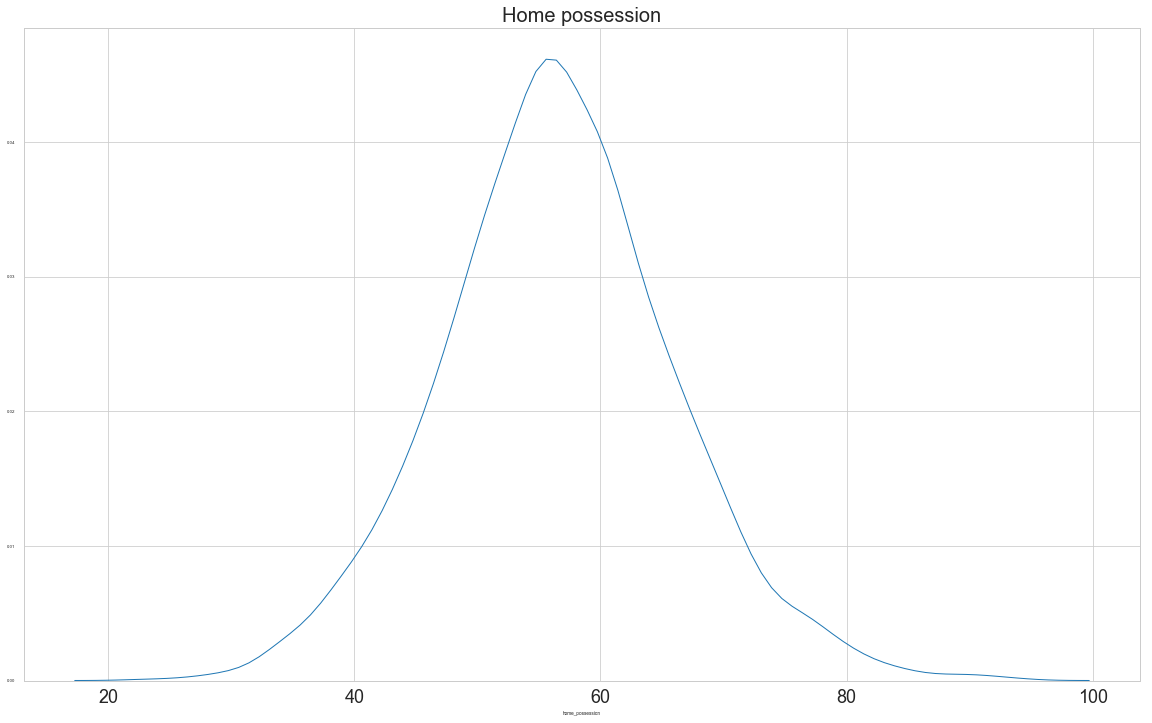

In [178]:
sns.distplot(match_data.home_possession.astype(int), hist=False)
plt.title('Home possession', fontsize=20)
plt.xticks(fontsize=18)
plt.show()

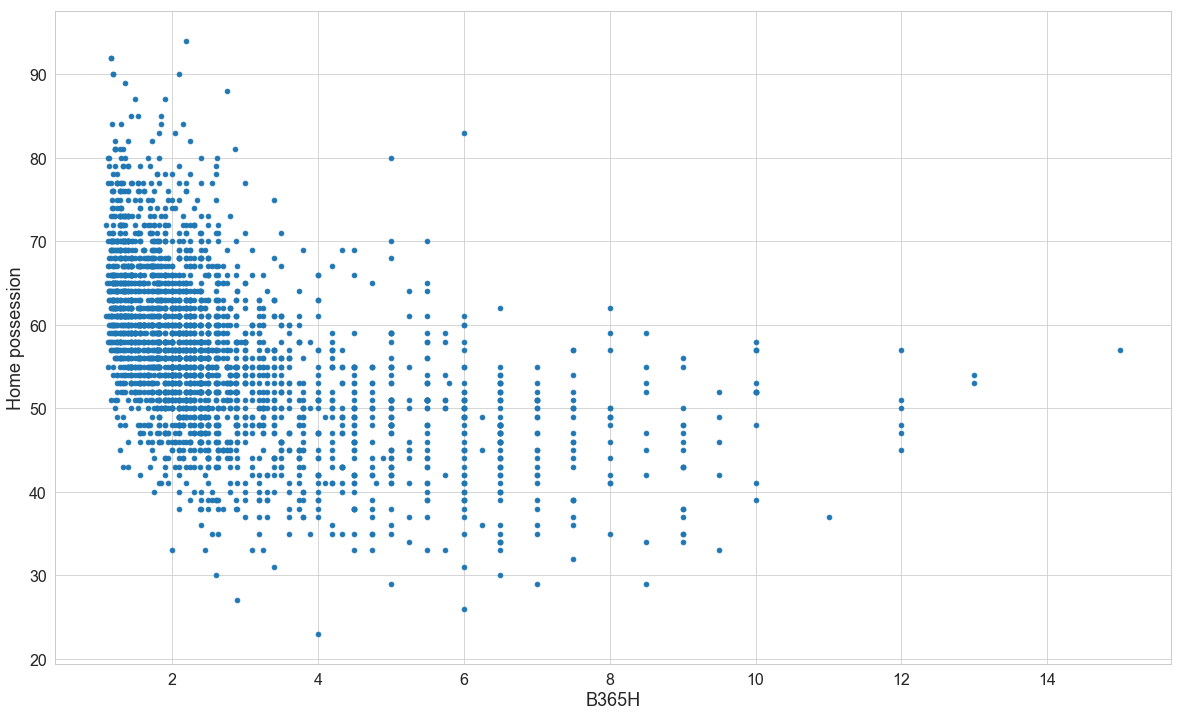

In [185]:
plt.scatter(match_data.B365H, match_data.home_possession.astype(int))
plt.xlabel('B365H', fontsize=18)
plt.ylabel('Home possession', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [186]:
np.corrcoef(match_data.B365H, match_data.home_possession.astype(int))

array([[ 1.        , -0.48780095],
       [-0.48780095,  1.        ]])

In [188]:
match_data.loc[:, 'total_prob'] = 1./match_data.B365H + 1./match_data.B365D + 1./match_data.B365A
match_data.loc[:, 'pct_win_prob'] = (1./ match_data.B365H) / match_data.total_prob
match_data.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_possession,total_prob,pct_win_prob
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,12.00,1.30,4.75,10.0,1.29,4.50,11.00,56,1.047921,0.739744
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,13.00,1.22,5.50,13.0,1.22,5.00,13.00,66,1.053846,0.790754
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.65,5.00,3.40,1.7,4.50,3.40,1.73,48,1.058398,0.171786
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,4.35,1.91,3.25,4.0,1.91,3.25,3.80,56,1.055773,0.495902
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,4.35,1.91,3.25,4.0,1.91,3.30,3.75,54,1.048625,0.499283


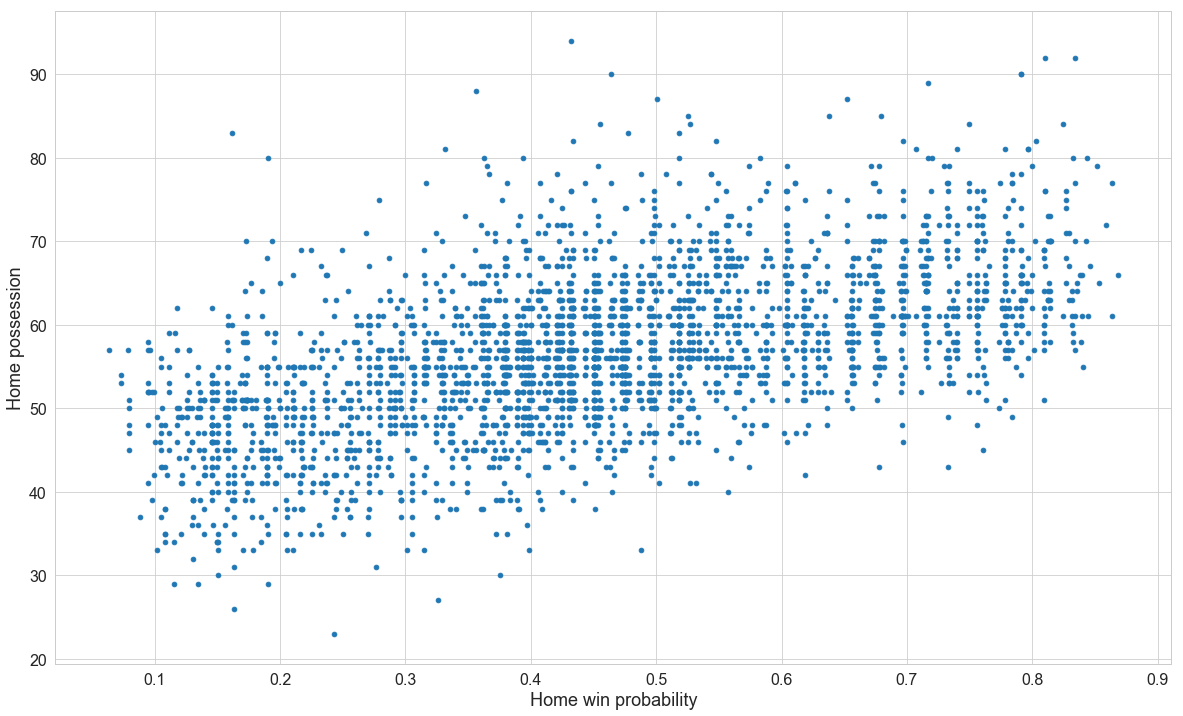

In [190]:
plt.scatter(match_data.pct_win_prob, match_data.home_possession.astype(int))
plt.xlabel('Home win probability', fontsize=18)
plt.ylabel('Home possession', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [191]:
np.corrcoef(match_data.pct_win_prob, match_data.home_possession.astype(int))

array([[1.        , 0.56845965],
       [0.56845965, 1.        ]])

Text(0.5,1,'Correllation between possession and result')

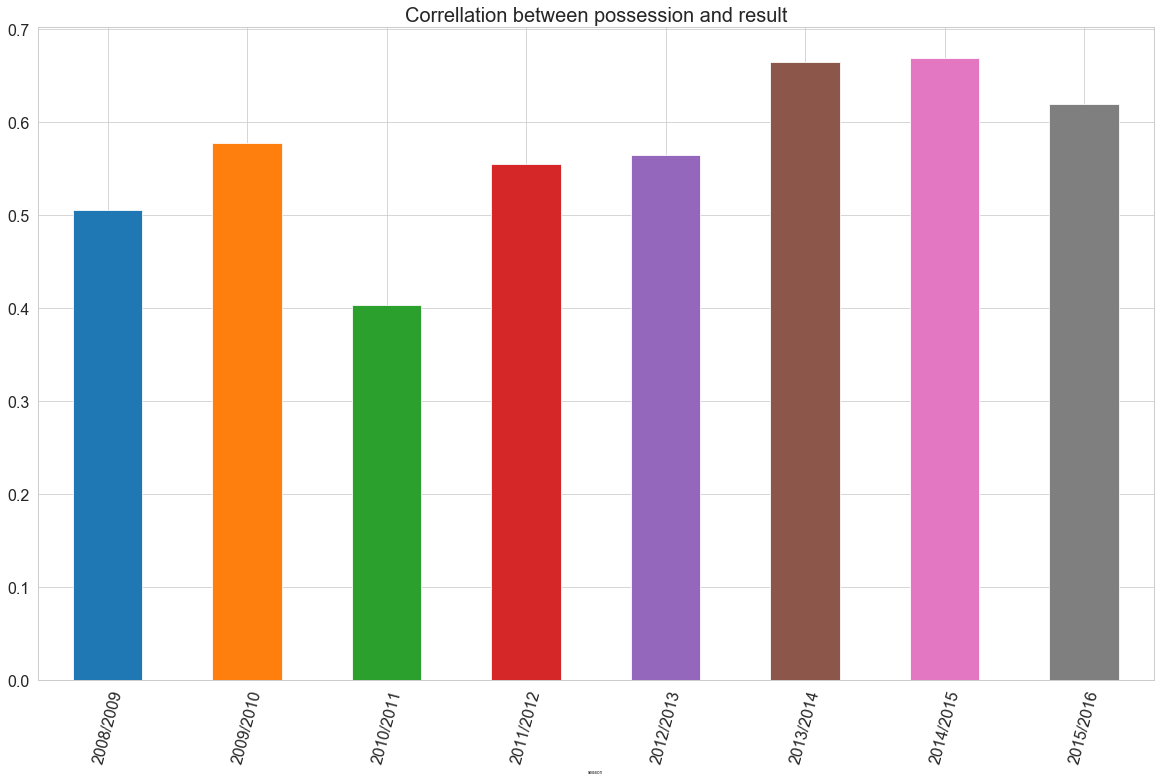

In [199]:
match_data.groupby('season').apply(
    lambda x: np.corrcoef(x.pct_win_prob, x.home_possession.astype(int))[0][1]
).plot(kind='bar', fontsize=16)
plt.xticks(rotation=75)
plt.title('Correllation between possession and result', fontsize=20)

In [283]:
match_data = pd.read_sql("SELECT * FROM Match where country_id = 1729;", conn)

In [284]:
match_data.loc[:, 'home_possession'] = match_data.possession.apply(lambda x: get_posession_things(x))
match_data.loc[:, 'total_prob'] = 1./match_data.B365H + 1./match_data.B365D + 1./match_data.B365A
match_data.loc[:, 'pct_win_prob'] = (1./ match_data.B365H) / match_data.total_prob
match_data.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_possession,total_prob,pct_win_prob
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,12.00,1.30,4.75,10.0,1.29,4.50,11.00,56,1.047921,0.739744
1,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,13.00,1.22,5.50,13.0,1.22,5.00,13.00,66,1.053846,0.790754
2,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.65,5.00,3.40,1.7,4.50,3.40,1.73,48,1.058398,0.171786
3,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,4.35,1.91,3.25,4.0,1.91,3.25,3.80,56,1.055773,0.495902
4,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,4.35,1.91,3.25,4.0,1.91,3.30,3.75,54,1.048625,0.499283


In [217]:
match_data.groupby(['season']).apply(
    lambda x: np.corrcoef(x.pct_win_prob, x.home_possession.astype(int))[0][1]
)

season
2008/2009    0.505481
2009/2010    0.578058
2010/2011    0.403628
2011/2012    0.554614
2012/2013    0.565233
2013/2014    0.665284
2014/2015    0.668790
2015/2016    0.620094
dtype: float64

In [223]:
match_data.groupby(['season']).apply(
    lambda x: np.corrcoef(x.home_team_goal >= x.away_team_goal, x.home_possession.astype(int))[0][1]
).head()

season
2008/2009    0.197999
2009/2010    0.278847
2010/2011    0.199495
2011/2012    0.307375
2012/2013    0.216577
dtype: float64

In [226]:
match_data.groupby(['season']).apply(
    lambda x: np.corrcoef(x.home_team_goal, x.home_possession.astype(int))[0][1]
)

season
2008/2009    0.168254
2009/2010    0.353881
2010/2011    0.240431
2011/2012    0.348583
2012/2013    0.260217
2013/2014    0.191843
2014/2015    0.117070
2015/2016    0.136394
dtype: float64

In [298]:
def get_player_name(x):
    player_base = None
    try:
        player_base = player_data[player_data.player_api_id.astype(int) == x].player_name.values[0]
    except:
        pass
    return player_base
        
match_data.home_player_1.astype(int).apply(lambda x: get_player_name(x)).head()

0    Edwin van der Sar
1       Manuel Almunia
2         Craig Gordon
3         Robert Green
4         Brad Friedel
Name: home_player_1, dtype: object

In [301]:
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)

for col in ['home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9',
       'home_player_10', 'home_player_11']:
    match_data.loc[:, col] = match_data[[col]].astype(int).apply(lambda x: get_player_name(x))
    
match_data.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_possession,total_prob,pct_win_prob
